# Valuation of Options with Early Exercise

**Fall 2025 Quantiative Methods in Finance**

**The Erdös Institute**

**Alexander Mason**

In [48]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize
import scipy.special as sps
from numpy.polynomial.laguerre import laggauss

from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

In [46]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call & put option with respect to sigma
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return S0*norm.pdf(d1)*np.sqrt(t)


##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan
    
def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')
    
    
    
## Heston functions using the characteristic function of the Heston model derived by Heston.

def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - call_price (float): Call option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Delta of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - delta (float): Call option delta
    """


    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    return P1

def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a European put option under the Heston model using put-call parity.

    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - put_price (float): Put option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)  # via put-call parity

    return put_price


def heston_put_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Delta of a put option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - delta (float): Put option delta
    """


    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    return P2



def heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - option_type (string): 'call' for call and 'put' for put

    Returns:
    - price (float): Option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)
    
    if option_type == 'call':
        return call_price
    
    if option_type == 'put':
        return put_price


def heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps):
    """
    Heston stock path simulation
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - n_sims (int): Number of simulated paths
    - n_steps (int): Number of steps in each simulated path

    Returns:
    - np array of simulated stock paths
    """


    dt = t/n_steps


    times = np.linspace(0,t, n_steps + 1)


    #noise in random processes with correlation rho

    noise1 = np.random.normal(size = (n_sims,n_steps))

    Y = np.random.normal(size = (n_sims,n_steps))

    noise2 = rho*noise1 + np.sqrt(1-rho**2)*Y #noise1 and noise2 both standard normal, but have correlation rho


    vols = np.zeros((n_sims,n_steps))

    vols[:,0] = v0

    for i in range(1, n_steps):
        vols[:,i] = vols[:,i-1] + kappa*(theta - vols[:,i-1])*dt + xi*np.sqrt(vols[:,i-1]*dt)*noise1[:,i-1]
        vols[:,i] = np.maximum(vols[:,i], 0)

    log_returns = (mu + r - vols/2)*dt + np.sqrt(vols*dt)*noise2

    exponent = np.cumsum(log_returns, axis = 1)

    paths = S0*np.exp(exponent)

    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths

# Early Exercise

Some options, particularly those traded in American markets, allow their holder to exercise early. The holder of such a call may buy the underlying stock, at the strike price, at any time up to the option's expiration, while the holder of such a put may sell at the strike price at any time up to expiration. The goal of this project is to determine when an option should be immediately exercised, and to compute the value of an option for which early exercise is possible.

Now providing additional rights to the holder of an option certain cannot decrease its value. However, at first glance it may seem unlikely that early exercise, which exchanges the option's total value for its inherent value (S-K for calls, K-S for puts), would ever be desirable. However, some such circumstances appear after considering the effect of dividends and time discounting.

**Reasons to exercise a call early: the effect of dividends**

Dividends, which consist of a predetermined value subtracted from the value of a stock and paid as cash to the holder, are a negligible concern for holders of the underlying stock, or of options without an early exercise clause. A holder of the underlying can immediately, if they so choose, reinvest the dividend in the same stock, and see no change in the value of their portfolio. Meanwhile, a trader of European options can account for dividends by incorporating them into the drift term mu. For example, if an expected 2% of the stock's present value is to be paid out yearly as dividends, then one should decrease mu by .02. Therefore, if an option position is correctly hedged so that the influence of mu disappears, one expects dividends to have no effect at all, on average, on the value of a portfolio.

However, if a stock may be purchased or sold at any time, at a fixed price, then it matters whether the transaction is made before or after the stock's ex-dividend date (the earliest date on which a purchaser will not collect the dividend). For a deeply in-the-money call, the time-discounted value of the future dividends plus the call's inherent value may exceed the expected value if held to expiration, in which case the option should be exercised on the day before the ex-dividend date.

**Reasons to exercise a put early: the effect of time discounting**

When an option is to be held to expiration, the expected value must be discounted by the risk-free interest rate to obtain the option's present value. In the case of a deeply in-the-money put, this present value may be less than K-S, meaning that the put should be exercised immediately. However, when making this comparison, one should take care to incorporate expected dividends. A smaller mu will have a positive impact on the value of a put held until expiration, making early exercise less desirable.

**Implementation of early exercise in the Black-Scholes model**

To compute the value of an option at time 0 = t_n, we work backwards from the time of expiration t_0, at which point the value will be known for all possible spot prices. Then, inductively, at each step t_i, we first determine the expected value if the option is held until t_{i-1}, using the output of the previous step. Then, for each value, we take the maximum with the profit that would be obtained by exercising the option immediately. (For calls, this is only necessary on days immediately preceding an ex-dividend date.)

The main practical difficulty is that we cannot, in finite time, compute option values at the infinitely many possible spot prices. Instead, we choose a level of granularity dS, and a domain [A, B] suitable for the underlying stock in question, then represent the valuation function as a vector indexed by values in [A, B] with spacing dS.  Then, going from the values at time t_{i-1} to the expected values at time t_i is accomplished by multiplying this vector by a suitable matrix, which is the same for all i, then taking maximum with [quantity]. One unfortunate effect is that our stochastic model will act as if the stock cannot leave the range [A, B], and therefore valuations will become increasingly inaccurate as the spot price approaches the in-the-money end. However, as long as at least one correction is made for the possibility of early exercise (i.e. the option is not a call on a non-dividend stock), then these inaccurate prices will be replaced with the early-exercise value. It is still advisable to choose a much wider range than is actually needed.

In [51]:
#Black-Scholes option valuations with early exercise

# K: strike price
# sigma: annualized volatility of underlying stock
# t: time to expiration in days
# r: risk-free interest rate
# mu: drift factor (not including dividends)
# A: lower bound of spot price domain
# B: upper bound of spot price domain
# dS: spacing of spot price domain
# dividends: list of pairs, each of which is the number of trading days between an ex-dividend date and the option's expiration (in reverse chronological order),
# followed by the value of the dividend, time-discounted to the ex-dividend date.

def am_bs_call(K, sigma, t, r, mu, A, B, dS, dividends):
    #number of points in domain
    L = int((B-A)/dS)
    S = np.linspace(A, A+L*dS, L+1)

    #scaling to measure time in days
    sigma *= np.sqrt(1/252)
    r = r/252
    mu = mu/252

    #stochastic matrix for daily price changes
    matrix = []
    #time discounting for a single day
    R = np.exp(-r)
    for i in range(L+1):
        #discrete approximation of log-normal distribution, normalized to have a sum of 1
        row = np.exp(-(np.log(S/(A+i*dS)) - mu + (sigma**2)/2)**2 / (2*sigma**2))/S
        matrix.append(R*row/np.sum(row))
    
    values = np.maximum(S-K, 0)
    d = 0
    D = len(dividends)
    total_dividends = 0
    for i in range(t):
        values = np.dot(matrix, values)
        #time discounted value of future dividends
        total_dividends *= R
        if d < D:
            if i == dividends[d][0]:
                total_dividends += dividends[d][1]
                d += 1
                #taking maximum with value of option if exercised immediately
                values = np.maximum(values, S-K + total_dividends)
    return(np.maximum(values, S-K))

def am_bs_put(K, sigma, t, r, mu, A, B, dS, dividends):
    L = int((B-A)/dS)
    S = np.linspace(A, A+L*dS, L+1)
    sigma *= np.sqrt(1/252)
    r = r/252
    mu = mu/252
    R = np.exp(-r)

    matrix = []
    for i in range(L+1):
        row = np.exp(-(np.log(S/(A+i*dS)) - mu + (sigma**2)/2)**2 / (2*sigma**2))/S
        matrix.append(R*row/np.sum(row))
    
    values = np.maximum(K-S, 0)
    d = 0
    D = len(dividends)
    total_dividends = 0
    for i in range(t):
        values = np.dot(matrix, values)
        total_dividends *= R
        if d < D:
            if i == dividends[d][0]:
                total_dividends += dividends[d][1]
                d += 1
        #a put may be worth exercising on any date, not just ones immediately preceding ex-dividend dates
        values = np.maximum(values, K-S - total_dividends)
    return(np.maximum(values, K-S))

# Gives the value added by the possibility of early exercise
def am_bs_call_added(K, sigma, t, r, mu, A, B, dS, dividends):
    L = int((B-A)/dS)
    S = np.linspace(A, A+L*dS, L+1)
    sigma *= np.sqrt(1/252)
    r = r/252
    mu = mu/252
    R = np.exp(-r)

    matrix = []
    for i in range(L+1):
        row = np.exp(-(np.log(S/(A+i*dS)) - mu + (sigma**2)/2)**2 / (2*sigma**2))/S
        matrix.append(R*row/np.sum(row))
    
    values_am = np.maximum(S-K, 0)
    values_eu = np.maximum(S-K, 0)
    d = 0
    D = len(dividends)
    total_dividends = 0
    for i in range(t):
        values_am = np.dot(matrix, values_am)
        values_eu = np.dot(matrix, values_eu)
        total_dividends *= R
        if d < D:
            if i == dividends[d][0]:
                total_dividends += dividends[d][1]
                d += 1
                values_am = np.maximum(values_am, S-K + total_dividends)
    #take maximum with S-K to remove most of the error introduced by the finite domain
    return(np.maximum(values_am, S-K+total_dividends) - np.maximum(values_eu, (S-K)))

def am_bs_put_added(K, sigma, t, r, mu, A, B, dS, dividends):
    L = int((B-A)/dS)
    S = np.linspace(A, A+L*dS, L+1)
    sigma *= np.sqrt(1/252)
    r = r/252
    mu = mu/252
    R = np.exp(-r)

    matrix = []
    for i in range(L+1):
        row = np.exp(-(np.log(S/(A+i*dS)) - mu + (sigma**2)/2)**2 / (2*sigma**2))/S
        matrix.append(R*row/np.sum(row))
    
    values_am = np.maximum(K-S, 0)
    values_eu = np.maximum(K-S, 0)
    d = 0
    D = len(dividends)
    total_dividends = 0
    immediate_ex_value = np.zeros(L)
    for i in range(t):
        values_am = np.dot(matrix, values_am)
        values_eu = np.dot(matrix, values_eu)
        total_dividends *= R
        if d < D:
            if i == dividends[d][0]:
                total_dividends += dividends[d][1]
                d += 1
        #profit for exercising today instead of waiting for tomorrow
        immediate_ex_value = K-S - total_dividends - values_am
        values_am = np.maximum(values_am, K-S - total_dividends)
    #finding the maximum S for which the put should be exercised today. If L is very large it would probably be worthwhile to replace this with a binary search.
    if put_added_value[1][0] <= 0:
        print('This put should not be exercised today, regardless of S.')
    else:
        for i in range(L):
            if put_added_value[1][i] <= 0:
                print('This put should be exercised today if S is less than')
                print(A+(i*dS))
                break
    return([values_am - np.maximum(values_eu, np.exp(-r*t)*(K-S)), immediate_ex_value])

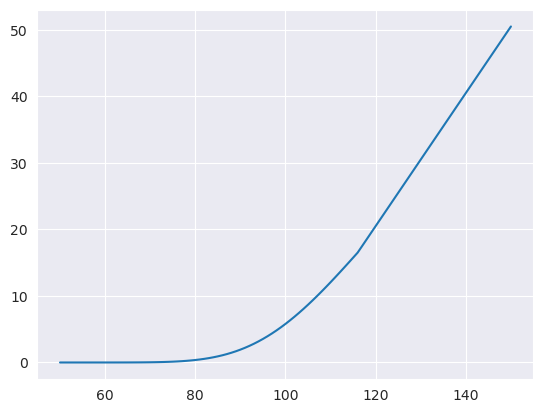

In [58]:
K = 100
sigma = .3
t = 61
r = .035
mu = 0
A = 50
B = 150
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
call_prices = am_bs_call(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, call_prices)
plt.show()

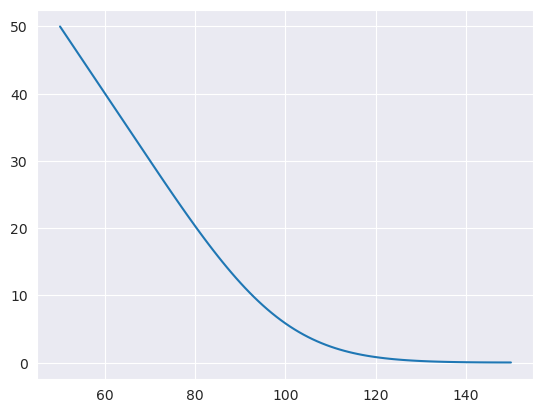

In [59]:
K = 100
sigma = .3
t = 61
r = .035
mu = 0
A = 50
B = 150
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
put_prices = am_bs_put(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, put_prices)
plt.show()

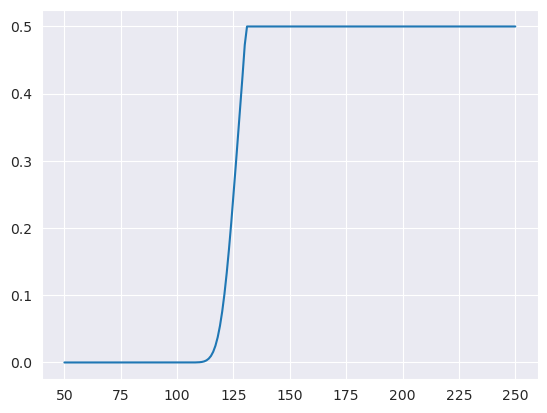

In [60]:
K = 100
sigma = .3
t = 65
r = .035
mu = 0
A = 50
B = 250
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
call_added_value = am_bs_call_added(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, call_added_value)
plt.show()

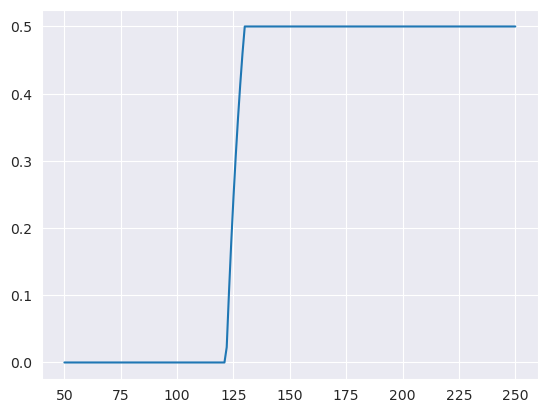

In [61]:
K = 100
sigma = .3
t = 61
r = .035
mu = 0
A = 50
B = 250
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
call_added_value = am_bs_call_added(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, call_added_value)
plt.show()

**Limitations of the model**

The most serious limitation of the above is computation power. The above algorithm scales quadratically with the number of points in the domain, and linearly with time to expiration. Thankfully, the outputs do not change greatly when passing from dS = 1, to 0.1, to 0.01, so a coarse domain will suffice for most purposes.

Another issue is the finite domain. The expected value of a call where the spot price is currently near B will appear much lower if we assume for computation purposes that the stock cannot rise above B. The same is true for a put with spot price near A. I have taken the maximum of the output with the option's inherent value to smooth out these errors, but the fact remains that the time value of options near the domain boundaries will be inaccurate, and if one wants option values at a certain spot price, the domain should be extended as far as necessary for the output to stabilize.

Finally, I was unable to adapt this algorithm to the Heston model.

**Using the model to determine when a call should be exercised early**

The model outputs an array whose indices i are related to the spot price S by the formula S = A + i*dS. So for example, in the graph immediately above, we see what is almost a step function. If i>70, i.e. S>120, then the value of this American call option is greater than the value it would have if it were European, and this added value can be gained by exercising the option immediately, since it is currently one day before an ex-dividend date. When it is not currently a date on which calls should be exercised, we see a more gradual increase in value as the spot price increases, reflecting an increasing probability that the price will be greater than 120 in four days. Even at prices below 120, the option will be currently trading above its European counterpart due to the potential of it becoming worthwhile to exercise early and obtain the dividend. Note that regardless of the spot price, the call should not be exercised until the last day on which it is possible to receive the dividend.

This put should not be exercised today, regardless of S.


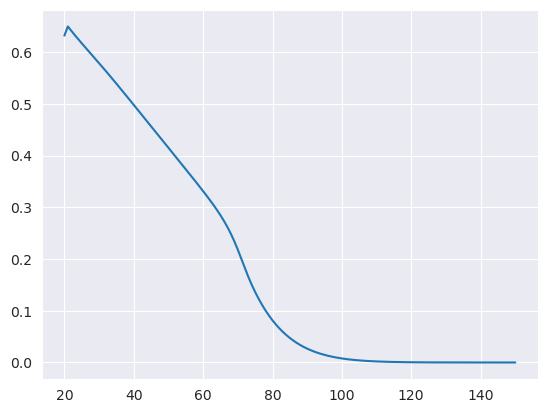

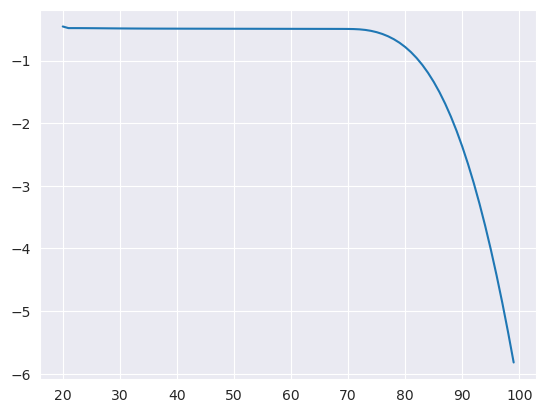

In [67]:
K = 100
sigma = .3
t = 61
r = .035
mu = 0
A = 20
B = 150
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
put_added_value = am_bs_put_added(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, put_added_value[0])
plt.show()
plt.plot(S[:80], put_added_value[1][:80])
plt.show()

This put should be exercised today if S is less than
72


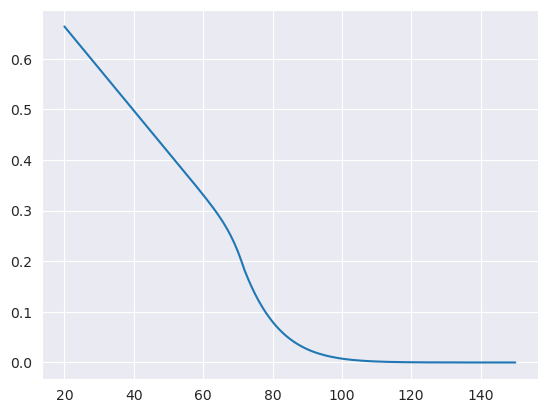

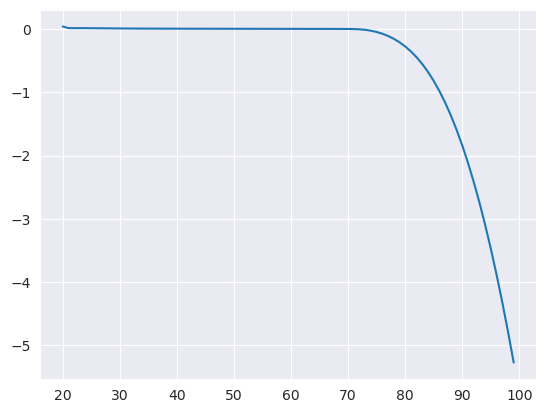

In [70]:
K = 100
sigma = .3
t = 60
r = .035
mu = 0
A = 20
B = 150
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
put_added_value = am_bs_put_added(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, put_added_value[0])
plt.show()
plt.plot(S[:80], put_added_value[1][:80])
plt.show()

This put should be exercised today if S is less than
73


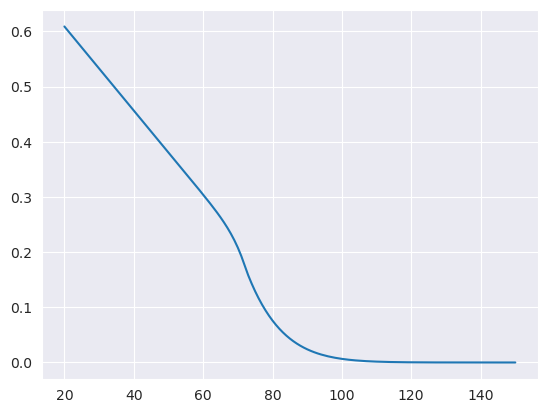

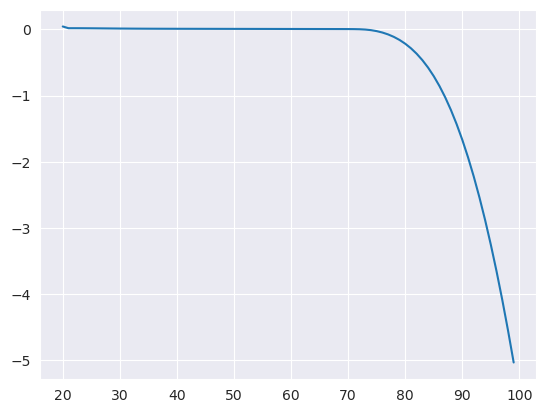

In [73]:
K = 100
sigma = .3
t = 55
r = .035
mu = 0
A = 20
B = 150
dS = 1
dividends = [[60, .5], [120, .5], [180, .5], [240, .5]]
L = int((B-A)/dS)
S = np.linspace(A, A+L*dS, L+1)
put_added_value = am_bs_put_added(K, sigma, t, r, mu, A, B, dS, dividends)
plt.plot(S, put_added_value[0])
plt.show()
plt.plot(S[:80], put_added_value[1][:80])
plt.show()

**Using the model to determine when a put should be exercised early**

The graph of the benefit for exercising a put early does not look like a mirror image of the corresponding one for a call. This is because while exercising a call early is done for the sake of obtaining the dividend, exercising a put results in an immediate cash payout, and the net gain is the interest on that cash, which grows linearly as the spot price continues to decrease.

There is an additional consideration for a holder of an American put: given that early exercise is currently providing additional value to the put, should this privilege be exercised specifically today, or it is better to wait until tomorrow? This consideration must be made every day that the put is in the money. The function therefore includes a second output vector for puts, which shows the expected profit from exercising the put today, or alternatively, the expected loss due to holding the put until tomorrow. Since these gains are usually too small to read off the graph, it also includes a simple search that prints the largest S for which the put should be exercised immediately. Note that while the best dates to exercise a put are ex-dividend dates, it may still be profitable, although typically less so, to exercise one on a different date.